Additional interface analysis workflow including:
- Gibbs free energy
- Hydrophobic buried surface area
- Residue contacts and predicted bonds formed at interface

## Gibbs free energy and hydrophobic buried surface area

### relabeling
relabel relaxed outputs (alphafold natively labels all rows of .pdb files as chain A), align sequence to targets.tsv[target_chainseq] column so
chain A will become pMHC and chain B will become TCR

In [5]:
from Bio.PDB import PDBParser, PDBIO, Chain, Model, Structure
from pathlib import Path
import pandas as pd

# === Constants ===
scratch_root = Path("/scratch/ggrama/tcrgen")
log = []

# === Load and index all available targets.tsv files ===
targets_map = {}
for tsv_path in scratch_root.glob("**/user_outputs/**/targets.tsv"):
    base_id = tsv_path.parent.name.split("_run")[0]
    targets_map[base_id] = tsv_path

# === Extraction logic ===
def extract_interface_relabel_plan(targets_tsv_path):
    df = pd.read_csv(targets_tsv_path, sep='\t')
    row = df.iloc[0]
    chain_seqs = row['target_chainseq'].split('/')
    if len(chain_seqs) != 4:
        raise ValueError(f"Unexpected number of chain segments: {len(chain_seqs)}")
    lengths = [len(seq) for seq in chain_seqs]
    offsets = [0]
    for length in lengths[:-1]:
        offsets.append(offsets[-1] + length)
    mhc_start, peptide_start, tcra_start, tcrb_start = offsets
    chain_A = list(range(mhc_start, tcra_start))                    # MHC + peptide
    chain_B = list(range(tcra_start, tcrb_start + lengths[3]))     # TCRα + TCRβ
    return chain_A, chain_B

# === Relabeling logic ===
def relabel_and_split_chains(input_pdb_path, output_pdb_path, chain_A_indices, chain_B_indices):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("complex", str(input_pdb_path))
    model = structure[0]

    chain_A = Chain.Chain('A')
    chain_B = Chain.Chain('B')
    flat_index = 0

    for chain in model:
        for residue in chain:
            if flat_index in chain_A_indices:
                chain_A.add(residue.copy())
            elif flat_index in chain_B_indices:
                chain_B.add(residue.copy())
            flat_index += 1

    new_model = Model.Model(0)
    if len(chain_A) > 0:
        new_model.add(chain_A)
    if len(chain_B) > 0:
        new_model.add(chain_B)

    new_structure = Structure.Structure("relabeled")
    new_structure.add(new_model)

    io = PDBIO()
    io.set_structure(new_structure)
    io.save(str(output_pdb_path))

# === Main loop: process all relaxed PDBs ===
for pdb_path in scratch_root.glob("**/relaxed/*.pdb"):
    pdb_name = pdb_path.stem
    try:
        if "_run" not in pdb_name:
            raise ValueError("Missing '_run' in filename")
        user_target_id = pdb_name.split("_run")[0]
    except Exception as e:
        log.append((str(pdb_path), f"❌ Could not parse ID: {e}"))
        continue

    targets_tsv = targets_map.get(user_target_id)
    if targets_tsv is None:
        log.append((str(pdb_path), f"❌ No targets.tsv for {user_target_id}"))
        continue

    try:
        chain_A, chain_B = extract_interface_relabel_plan(targets_tsv)
        relabeled_dir = pdb_path.parent.parent / "relabeled"
        relabeled_dir.mkdir(parents=True, exist_ok=True)
        output_pdb = relabeled_dir / f"{pdb_name}_relabeled.pdb"
        if output_pdb.exists():
            log.append((str(pdb_path), "⏭️ Already relabeled"))
            continue

        relabel_and_split_chains(pdb_path, output_pdb, chain_A, chain_B)
        log.append((str(pdb_path), "✅ Relabeled"))
    except Exception as e:
        log.append((str(pdb_path), f"❌ Failed: {e}"))

# === Save log ===
pd.DataFrame(log, columns=["Structure", "Status"]).to_csv("relabel_log.csv", index=False)
print("Relabeling complete. Log saved to relabel_log.csv")


Relabeling complete. Log saved to relabel_log.csv


### inputs for interface.sh

In [7]:
from pathlib import Path

# === Config ===
ROOT_DIR = Path("/scratch/ggrama/tcrgen")
OUTPUT_FILE = Path("/home/ggrama/tcrgen/scripts/relabeled_paths.txt")

# === Remove old output if it exists ===
OUTPUT_FILE.unlink(missing_ok=True)

# === Find all relabeled .pdb files ===
relabeled_pdbs = ROOT_DIR.rglob("*/relabeled/*.pdb")
missing = []

for pdb_path in relabeled_pdbs:
    # /.../relabeled/{id}/file.pdb
    relabeled_dir = pdb_path.parent
    base_dir = relabeled_dir.parent  # one level up from relabeled/
    interface_dir = base_dir / "interface_scores"
    expected_score = interface_dir / (pdb_path.stem + "_scores.sc")

    if not expected_score.exists():
        # ✅ Append the actual existing relabeled pdb path
        missing.append(pdb_path)

# === Write to output file ===
if missing:
    OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(OUTPUT_FILE, "w") as f:
        for path in missing:
            f.write(str(path) + "\n")
    print(f"Missing interface scores written to: {OUTPUT_FILE}")
    print(f"Count: {len(missing)}")
else:
    print("All interface score files are present.")


Missing interface scores written to: /home/ggrama/tcrgen/scripts/relabeled_paths.txt
Count: 1


### interface analyzer results

In [56]:
import pandas as pd
from pathlib import Path
import os

# === Config ===
root_dir = Path("/scratch/ggrama/tcrgen")
output_csv = Path("/home/ggrama/tcrgen/compiled_interface_scores.csv")

# === Helper: get relative group identifier ===
def get_relative_id(input_path, root_dir="/scratch/ggrama/tcrgen"):
    rel_path = os.path.relpath(str(input_path), root_dir)
    parts = rel_path.split(os.sep)
    try:
        if parts[0] in {"gen5", "gen10"} and len(parts) > 1:
            return f"{parts[0]}_{parts[1]}"
        elif parts[0] == "controls" and len(parts) > 1:
            return f"controls_{parts[1]}"
        elif parts[0] == "gen0" and parts[1] in {"in_sample", "out_sample"} and len(parts) > 2:
            return f"{parts[0]}_{parts[1]}_{parts[2]}"
        else:
            return "solved" if "solved" in parts else "unknown"
    except IndexError:
        return "unknown"

# === Find all *_scores.sc files ===
score_files = list(root_dir.rglob("*/interface_scores/*_scores.sc"))
print(f"Found {len(score_files)} score files.")

compiled_rows = []

# === Parse each .sc file ===
for sc_file in score_files:
    header = None
    with open(sc_file) as f:
        for line in f:
            if line.startswith("SCORE:") and "description" in line:
                header = line.strip().split()[1:]  # skip "SCORE:"
                break
    if header is None:
        print(f"❌ No header in {sc_file}")
        continue

    group_id = get_relative_id(sc_file)
    with open(sc_file) as f:
        for line in f:
            if not line.startswith("SCORE:") or "description" in line:
                continue
            parts = line.strip().split()[1:]  # skip "SCORE:"
            if len(parts) != len(header):
                print(f"⚠️ Skipping malformed line in {sc_file}")
                continue
            row = dict(zip(header, parts))
            row["source"] = sc_file.name.replace("_scores.sc", "")
            row["path"] = str(sc_file)
            row["group_id"] = group_id
            compiled_rows.append(row)

# === Save compiled result
df_all = pd.DataFrame(compiled_rows)
df_all.to_csv(output_csv, index=False)
print(f"✅ Compiled {len(df_all)} rows to {output_csv}")


Found 3005 score files.
✅ Compiled 3005 rows to /home/ggrama/tcrgen/compiled_interface_scores.csv


/tmp/ipykernel_122906/2708553165.py:23: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="group_id", y="dG_separated", inner="quartile", scale="width", cut=0)


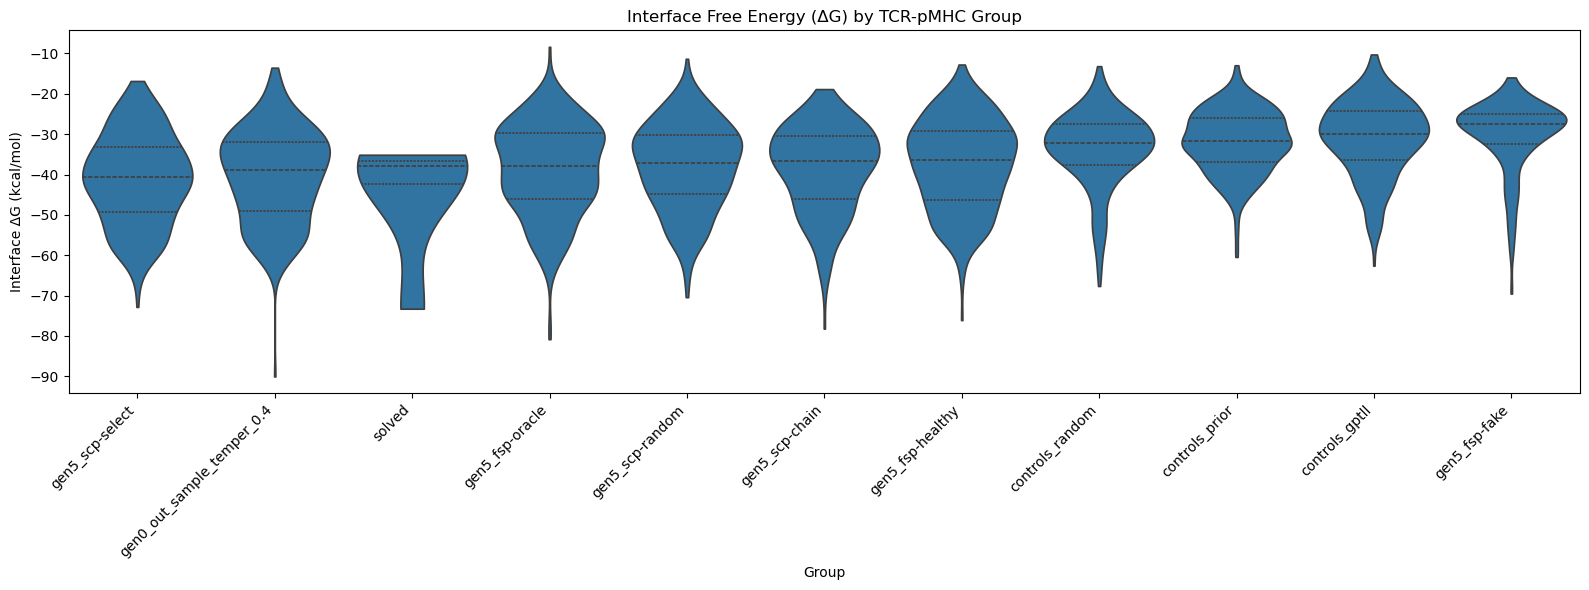

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load compiled scores
df = pd.read_csv("/home/ggrama/tcrgen/compiled_interface_scores.csv")

# === Convert dG_separated to float (if needed)
df["dG_separated"] = pd.to_numeric(df["dG_separated"], errors="coerce")

# === Drop rows with missing or invalid scores
df = df.dropna(subset=["dG_separated", "group_id"])

# === Sort groups by median free energy
group_medians = df.groupby("group_id")["dG_separated"].median().sort_values()
ordered_groups = group_medians.index.tolist()

# === Convert to ordered categorical
df["group_id"] = pd.Categorical(df["group_id"], categories=ordered_groups, ordered=True)

# === Plot
plt.figure(figsize=(16, 6))
sns.violinplot(data=df, x="group_id", y="dG_separated", inner="quartile", scale="width", cut=0)

# === Format
plt.xticks(rotation=45, ha="right")
plt.xlabel("Group")
plt.ylabel("Interface ΔG (kcal/mol)")
plt.title("Interface Free Energy (ΔG) by TCR-pMHC Group")
plt.tight_layout()
plt.show()


/tmp/ipykernel_122906/3255386510.py:21: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="group_id", y="dSASA_hphobic", inner="quartile", scale="width", cut=0)


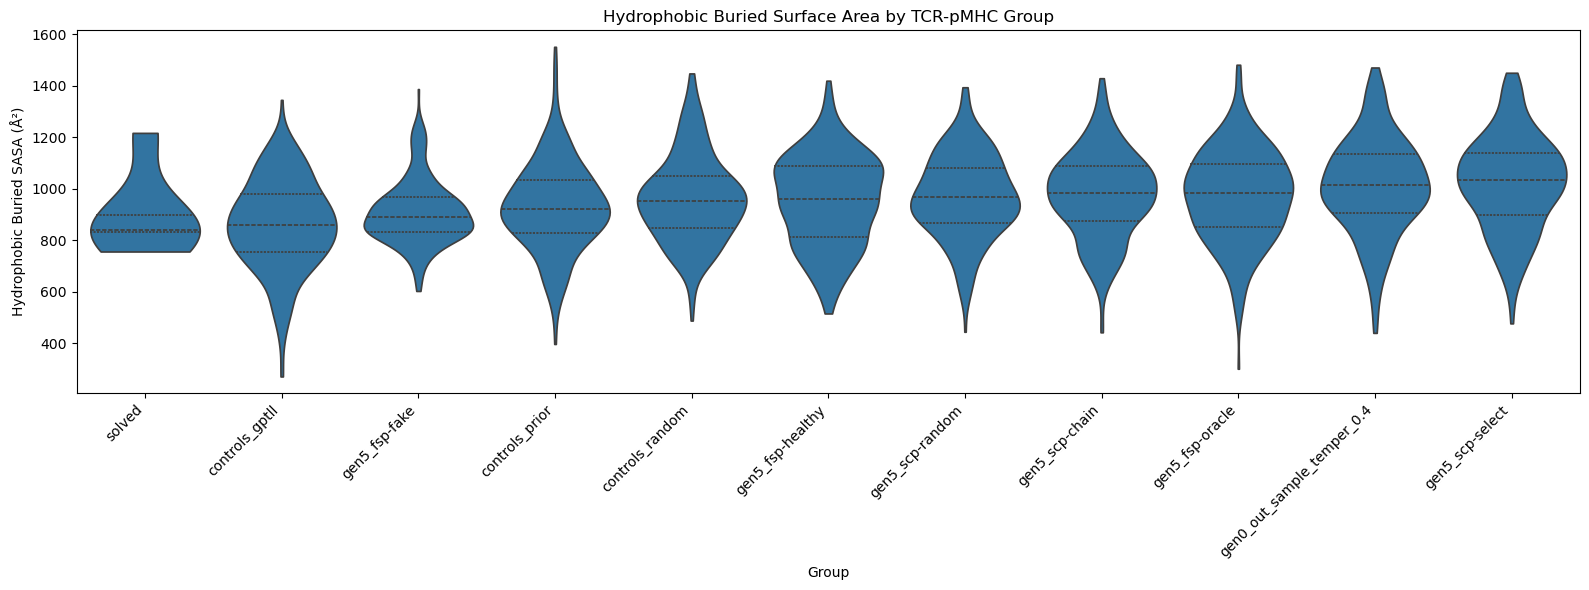

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load the compiled data
df = pd.read_csv("/home/ggrama/tcrgen/compiled_interface_scores.csv")

# === Ensure the column is numeric
df["dSASA_hphobic"] = pd.to_numeric(df["dSASA_hphobic"], errors="coerce")

# === Drop rows with missing values
df = df.dropna(subset=["dSASA_hphobic", "group_id"])

# === Sort groups by median hydrophobic surface area
group_medians = df.groupby("group_id")["dSASA_hphobic"].median().sort_values()
ordered_groups = group_medians.index.tolist()
df["group_id"] = pd.Categorical(df["group_id"], categories=ordered_groups, ordered=True)

# === Plot
plt.figure(figsize=(16, 6))
sns.violinplot(data=df, x="group_id", y="dSASA_hphobic", inner="quartile", scale="width", cut=0)

# === Format
plt.xticks(rotation=45, ha="right")
plt.xlabel("Group")
plt.ylabel("Hydrophobic Buried SASA (Å²)")
plt.title("Hydrophobic Buried Surface Area by TCR-pMHC Group")
plt.tight_layout()
plt.show()


## Interface residue contacts

### candidates
pull top 10 generated sequences with lowest rmsd from each group as potential canadidates to look in to

In [18]:
import pandas as pd

# === Load and clean RMSD data
df = pd.read_csv("/home/ggrama/tcrgen/cdr3b_epitope_rmsd_flexible.csv")
df["rmsd_flexible"] = pd.to_numeric(df["rmsd_flexible"], errors="coerce")
df = df.dropna(subset=["rmsd_flexible", "group_dir"])

# === Top 10 per group by RMSD
top10_per_group = (
    df.sort_values(by="rmsd_flexible")
      .groupby("group_dir", group_keys=False)
      .head(10)
)

# === Save full top 10 results
top10_path = "/home/ggrama/tcrgen/top10_cdr3b_epitope_rmsd_flexible.csv"
top10_per_group.to_csv(top10_path, index=False)
print(f"✅ Saved top 10 RMSD entries per group to {top10_path}")

# === Remove "controls" group entries
filtered_df = top10_per_group[~top10_per_group["group_dir"].str.startswith("controls")].reset_index(drop=True)

# === Save no-controls version
nocontrols_path = "/home/ggrama/tcrgen/top10_cdr3b_epitope_rmsd_flexible_nocontrols.csv"
filtered_df.to_csv(nocontrols_path, index=False)
print(f"✅ Saved filtered top 10 (no controls) to {nocontrols_path}")


✅ Saved top 10 RMSD entries per group to /home/ggrama/tcrgen/top10_cdr3b_epitope_rmsd_flexible.csv
✅ Saved filtered top 10 (no controls) to /home/ggrama/tcrgen/top10_cdr3b_epitope_rmsd_flexible_nocontrols.csv


### identify in contact residues at interface and label potential bonds
good candidates to visualize

In [19]:
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser, is_aa
from Bio.SeqUtils import seq1
from pathlib import Path
from scipy.spatial import distance_matrix
import os

# === Setup
CONTACT_DIR = Path("/home/ggrama/tcrgen/contact_batches")
CONTACT_DIR.mkdir(parents=True, exist_ok=True)

INPUT_CSV = Path("/home/ggrama/tcrgen/top10_cdr3b_epitope_rmsd_flexible_nocontrols.csv")
ROOT = Path("/scratch/ggrama/tcrgen")

# === Classification rules
acidic = {"ASP", "GLU"}
basic = {"ARG", "LYS", "HIS"}
hydrophobic = {"ALA", "VAL", "LEU", "ILE", "MET", "PHE", "TRP", "PRO"}

def classify_contact(atom1, atom2, dist):
    el1 = atom1.element or atom1.name[0]
    el2 = atom2.element or atom2.name[0]
    res1 = atom1.get_parent().resname.strip()
    res2 = atom2.get_parent().resname.strip()

    if el1 in {"N", "O"} and el2 in {"N", "O"} and dist <= 3.5:
        return "hydrogen_bond"
    if ((res1 in acidic and res2 in basic) or (res1 in basic and res2 in acidic)) and dist <= 4.0:
        return "salt_bridge"
    if res1 in hydrophobic and res2 in hydrophobic and dist <= 5.0:
        return "hydrophobic"
    return "generic_contact"

def extract_interface_info(targets_path):
    df = pd.read_csv(targets_path, sep='\t')
    row = df.iloc[0]
    chain_seqs = row['target_chainseq'].split('/')
    labels = ['mhc', 'peptide', 'tcra', 'tcrb']
    lengths = [len(seq) for seq in chain_seqs]
    offsets = [0]
    for l in lengths[:-1]:
        offsets.append(offsets[-1] + l)
    info = {
        "peptide_start": offsets[1],
        "peptide_end": offsets[2],
        "tcrb_start": offsets[3],
        "tcrb_seq": chain_seqs[3],
        "cdr3b": row["cdr3b"]
    }
    return info

def get_residues(pdb_path):
    structure = PDBParser(QUIET=True).get_structure("pred", pdb_path)
    return [res for res in structure[0]["A"] if is_aa(res)]

def get_sequence(residues):
    return "".join(seq1(res.resname.strip()) for res in residues)

def find_subseq_start(subseq, seq):
    return seq.find(subseq)

def find_contacts(peptide_atoms, cdr3b_atoms, cutoff=7.0):
    coords1 = np.array([a.coord for a in cdr3b_atoms])
    coords2 = np.array([a.coord for a in peptide_atoms])
    dmat = distance_matrix(coords1, coords2)

    contacts = []
    for i, atom1 in enumerate(cdr3b_atoms):
        for j, atom2 in enumerate(peptide_atoms):
            dist = dmat[i, j]
            if dist <= cutoff:
                res1 = atom1.get_parent()
                res2 = atom2.get_parent()
                contacts.append({
                    "cdr3b_res": f"{res1.resname.strip()}{res1.id[1]}",
                    "pep_res": f"{res2.resname.strip()}{res2.id[1]}",
                    "atom1": atom1.name.strip(),
                    "atom2": atom2.name.strip(),
                    "distance": dist
                })
    return contacts

# === Main loop
df = pd.read_csv(INPUT_CSV)

for _, row in df.iterrows():
    try:
        pred_pdb = row['predicted_pdb']
        group_dir = row['group_dir']
        gen = group_dir.split('_')[0]
        subgroup = "_".join(group_dir.split('_')[1:])

        if gen == "gen0" and subgroup.startswith("out_sample_temper_0.4"):
            relaxed_dir = "gen0/out_sample/temper_0.4"
            user_outputs_dir = "gen0/out_sample/temper_0.4"
        else:
            relaxed_dir = f"{gen}/{subgroup}"
            user_outputs_dir = f"{gen}/{subgroup}"

        target_id = pred_pdb.split('_run_')[0]
        pdb_path = ROOT / relaxed_dir / "relaxed" / pred_pdb
        targets_path = ROOT / user_outputs_dir / "user_outputs" / target_id / "targets.tsv"

        if not pdb_path.exists() or not targets_path.exists():
            print(f"[SKIP] Missing file for {pred_pdb}")
            continue

        relabel_info = extract_interface_info(targets_path)
        residues = get_residues(pdb_path)

        pep_res = residues[relabel_info["peptide_start"]:relabel_info["peptide_end"]]
        pep_atoms = [a for r in pep_res for a in r.get_atoms()]

        tcrb_res = residues[relabel_info["tcrb_start"]:]
        tcrb_seq = get_sequence(tcrb_res)
        cdr3b_seq = relabel_info["cdr3b"]

        start = find_subseq_start(cdr3b_seq, tcrb_seq)
        if start == -1:
            print(f"[FAIL] Could not find CDR3β in TCRβ sequence for {pred_pdb}")
            continue

        cdr3b_start = relabel_info["tcrb_start"] + start
        cdr3b_end = cdr3b_start + len(cdr3b_seq)
        cdr3b_res = residues[cdr3b_start:cdr3b_end]
        cdr3b_atoms = [a for r in cdr3b_res for a in r.get_atoms()]

        contacts = find_contacts(pep_atoms, cdr3b_atoms)

        # Classify
        contact_types = []
        for contact in contacts:
            res1 = contact["cdr3b_res"]
            res2 = contact["pep_res"]
            atom1 = contact["atom1"]
            atom2 = contact["atom2"]
            dist = contact["distance"]

            try:
                res1name = res1[:3]
                res1num = int(res1[3:])
                res2name = res2[:3]
                res2num = int(res2[3:])
                # Build atom keys
                a1 = next((a for a in cdr3b_atoms if a.get_parent().resname.strip() == res1name and a.get_parent().id[1] == res1num and a.name.strip() == atom1), None)
                a2 = next((a for a in pep_atoms if a.get_parent().resname.strip() == res2name and a.get_parent().id[1] == res2num and a.name.strip() == atom2), None)
                if a1 and a2:
                    contact_type = classify_contact(a1, a2, dist)
                else:
                    contact_type = "unknown"
            except:
                contact_type = "error"
            contact_types.append(contact_type)

        for i, ct in enumerate(contact_types):
            contacts[i]["contact_type"] = ct

        # Write output
        output_path = CONTACT_DIR / pred_pdb.replace(".pdb", "_contacts_annotated.csv")
        pd.DataFrame(contacts).to_csv(output_path, index=False)
        print(f"[DONE] {pred_pdb}: {len(contacts)} contacts → {output_path.name}")

    except Exception as e:
        print(f"[ERROR] {pred_pdb}: {e}")


[DONE] gen5_scp-chain_141_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb: 773 contacts → gen5_scp-chain_141_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv
[DONE] gen5_fsp-healthy_116_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb: 967 contacts → gen5_fsp-healthy_116_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv
[DONE] gen5_fsp-healthy_250_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb: 1119 contacts → gen5_fsp-healthy_250_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv
[DONE] gen5_fsp-fake_234_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb: 967 contacts → gen5_fsp-fake_234_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv
[DONE] gen5_scp-select_189_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001.pdb: 732 contacts → gen5_scp-select_189_run_T00000_A0201

In [20]:
import pandas as pd
from pathlib import Path
from collections import Counter, defaultdict

CONTACT_DIR = Path("/home/ggrama/tcrgen/contact_batches")

# Store totals across all files
overall_counter = Counter()

# Store counts per file
file_counters = defaultdict(Counter)

for csv_file in CONTACT_DIR.glob("*_contacts_annotated.csv"):
    df = pd.read_csv(csv_file)

    # Count occurrences of each contact_type, fill missing with 'unknown'
    counts = df['contact_type'].fillna('unknown').value_counts()
    
    # Update per-file counts
    file_counters[csv_file.name].update(counts.to_dict())
    
    # Update overall totals
    overall_counter.update(counts.to_dict())

# === Print per file summary ===
print("Bond type counts per file:")
for fname, counter in file_counters.items():
    print(f"\n{fname}:")
    for bond_type, count in counter.most_common():
        print(f"  {bond_type}: {count}")

# === Print overall summary ===
print("\n=== Overall Bond Type Counts ===")
for bond_type, count in overall_counter.most_common():
    print(f"{bond_type}: {count}")

Bond type counts per file:

gen5_fsp-fake_110_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv:
  generic_contact: 728
  hydrophobic: 48
  hydrogen_bond: 3

gen5_scp-select_58_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv:
  generic_contact: 722
  hydrophobic: 7

gen5_fsp-healthy_283_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv:
  generic_contact: 1125
  hydrophobic: 8

gen5_scp-random_105_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv:
  generic_contact: 641
  hydrophobic: 4
  hydrogen_bond: 1

gen0_out_sample_temper_0.4_152_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv:
  generic_contact: 1047
  hydrophobic: 69
  hydrogen_bond: 2

gen5_scp-chain_199_run_T00000_A0201_GILGFVFTL_0_model_1_model_2_ptm_relaxed_0001_contacts_annotated.csv:
  generic_contact: 926
  hydrophobic: 41
  hydrogen_bond: 1

g

In [21]:
import pandas as pd
from pathlib import Path

CONTACT_DIR = Path("/home/ggrama/tcrgen/contact_batches")
OUTPUT_CSV = Path("/home/ggrama/tcrgen/pdb_bond_ranking_with_types.csv")

excluded_types = {"generic_contact", "unknown"}

records = []

for csv_file in CONTACT_DIR.glob("*_contacts_annotated.csv"):
    df = pd.read_csv(csv_file)

    # Filter to bonds that matter
    filtered_df = df[~df['contact_type'].isin(excluded_types)]

    # Count bonds by type
    bond_counts = filtered_df['contact_type'].value_counts().to_dict()

    total_count = sum(bond_counts.values())
    base_name = csv_file.name.replace("_contacts_annotated.csv", "") + ".pdb"

    record = {
        "pdb_file": base_name,
        "total_strong_bonds": total_count,
    }
    # Add each bond type count as a separate column
    for bond_type, count in bond_counts.items():
        record[bond_type] = count

    records.append(record)

# Convert to DataFrame, fill missing bond types with 0
df_out = pd.DataFrame(records).fillna(0).sort_values("total_strong_bonds", ascending=False)

df_out.to_csv(OUTPUT_CSV, index=False)
print(f"Ranking with bond types saved to {OUTPUT_CSV}")


Ranking with bond types saved to /home/ggrama/tcrgen/pdb_bond_ranking_with_types.csv
